# **Customer Segmentation for Retail**
**Objective**
Segmenting customers into groups based on their purchasing behavior using clustering techniques.

# Importing necessary libraries

In [3]:
# libraries
import numpy as np                               
import pandas as pd                              
import seaborn as sns                             
import matplotlib.pyplot as plt                   
from sklearn.preprocessing import MinMaxScaler    
from sklearn.preprocessing import StandardScaler  
from sklearn.cluster import KMeans                
from sklearn.cluster import DBSCAN               
from sklearn.metrics import silhouette_score      
from sklearn.manifold import TSNE                 
from sklearn.decomposition import PCA
import os                                         
import warnings


# Ignore all warnings
warnings.filterwarnings('ignore')

# **Data Preparation**

### Reading and Showing Data Head

In [6]:
# Reading the Excel file
customer_data = pd.read_excel("Online_Retail.xlsx")


In [7]:
# Displaying the data
customer_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Data Cleaning

In [9]:
customer_data.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [10]:
customer_data.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [11]:
customer_data.shape

(541909, 8)

#### Displaying the missing values

In [13]:
customer_data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [14]:
# Filling the missing values

def fill_missing_values(customer_data):
    for column in customer_data.columns:
        if customer_data[column].isnull().sum():
            data_points = customer_data[column].value_counts(normalize=True, dropna=True)
            choices = data_points.index
            probabilities = data_points.values
            num_missing = customer_data[column].isna().sum()
            random_choices = np.random.choice(choices, size=num_missing, p=probabilities)
            customer_data.loc[customer_data[column].isna(), column] = random_choices
    return customer_data

customer_data=fill_missing_values(customer_data)

<Axes: >

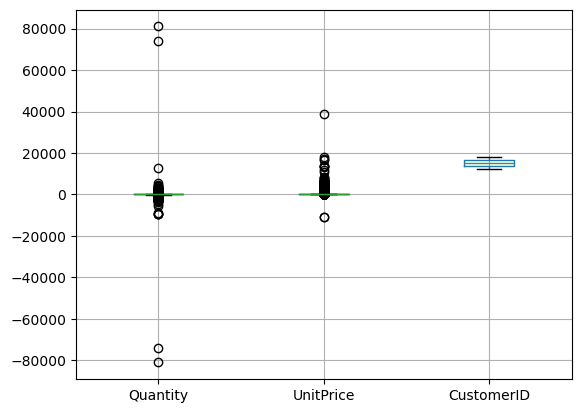

In [15]:
# checking for outliers
customer_data.boxplot()

### Calculating RFM Metrics
Here we are calculatig the following for each customer:

1. **`Recency`**: How recently the customer made a purchase.

2. **`Frequency`**: How often the customer makes a purchase.

3. **`Monetary`**: How much the customer spends.

In [17]:
# Creating Total_Price column
customer_data['Total_Price'] = customer_data['Quantity'] * customer_data['UnitPrice']

# Referencing date for recency calculation
reference_date = customer_data['InvoiceDate'].max()

# Creating new DataFrame, grouping by CustomerID and calculating RFM metrics
customer_data_rfm = customer_data.groupby('CustomerID').agg({
    # Calculating Recency as the number of days since the most recent purchase for each customer
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency (days since last purchase)

    # Counting the number of invoices for each customer to calculate Frequency
    'InvoiceNo': 'count',                                      # Frequency (number of transactions)

    # Calculating the total spending of each customer by summing the 'Total_Price'
    'Total_Price': 'sum'                                       # Monetary (total money spent)
})

# Renaming columns for clarity
customer_data_rfm = customer_data_rfm.rename(columns={
    'InvoiceDate': 'Recency',      # Renaming InvoiceDate column as Recency
    'InvoiceNo': 'Frequency',      # Renaming InvoiceNo column as Frequency
    'Total_Price': 'Monetary'      # Renaming Total_Price column as Monetary
}).reset_index()

# Saving preprocessed dataset
customer_data_rfm.to_csv('customer_data_rfm.csv', index=False)

# Displaying the first few rows of the RFM DataFrame
customer_data_rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,231,3,4.92
1,12347.0,1,239,4853.06
2,12348.0,0,40,1859.28
3,12349.0,1,103,2071.40
4,12350.0,0,24,440.22


### Normalize the Data
**To ensure that the clustering algorithm does not get biased by different scales of data, the RFM features is normalized.**

In [19]:
# Normalizing RFM data using Min-Max Scaling
scaler = MinMaxScaler()
customer_data_scaled = scaler.fit_transform(customer_data_rfm[['Recency', 'Frequency', 'Monetary']])

# Creating a new DataFrame for the scaled features
customer_data_normalized = pd.DataFrame(customer_data_scaled, columns= ['Recency','Frequency','Monetary'])

# Combining the normalized features with the CustomerID
customer_data_normalized = pd.concat([customer_data_rfm[['CustomerID']].reset_index(drop=True), customer_data_normalized], axis=1)

# Saving Normalized dataset
customer_data_normalized.to_csv('customer_data_normalized.csv', index=False) 

# Displaying the RFM DataFrame
print("RFM DataFrame before scaling the data:")
print(customer_data_rfm.head())

# Displaying the normalized RFM DataFrame
print("\nNormalized RFM DataFrame after scaling the data:")
print(customer_data_normalized.head())

RFM DataFrame before scaling the data:
   CustomerID  Recency  Frequency  Monetary
0     12346.0      231          3      4.92
1     12347.0        1        239   4853.06
2     12348.0        0         40   1859.28
3     12349.0        1        103   2071.40
4     12350.0        0         24    440.22

Normalized RFM DataFrame after scaling the data:
   CustomerID   Recency  Frequency  Monetary
0     12346.0  0.619303   0.000189  0.052492
1     12347.0  0.002681   0.022549  0.068376
2     12348.0  0.000000   0.003695  0.058567
3     12349.0  0.002681   0.009664  0.059262
4     12350.0  0.000000   0.002179  0.053918


# **Applying Clustering Algorithms**
**K-Means Clustering**

Applying **K-Means Clustering** to segment customers based on the RFM metrics.

In [31]:
# Applying K-Means with the optimal number of clusters
optimal_k = 8
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data_rfm['K_Cluster'] = kmeans.fit_predict(customer_data_scaled)

# Inspect clusters
print(customer_data_rfm.groupby('K_Cluster').mean())

             CustomerID     Recency    Frequency       Monetary
K_Cluster                                                      
0          15339.954933   22.224117    34.734470     625.696943
1          15466.606383  185.840426     9.872340     363.594043
2          15264.627907  345.255814     3.418605     161.881395
3          15484.284672  115.489051    13.072993     326.917518
4          15271.601303    2.461433   155.353103    2520.295928
5          15199.661017  265.762712     5.593220     169.667119
6          15084.285714    0.000000  3662.357143  116679.692143
7          15363.344948   60.986063    20.062718     532.735300


### Determining the Optimal Number of Clusters using the **Elbow Method** & **Silhouette Score**.

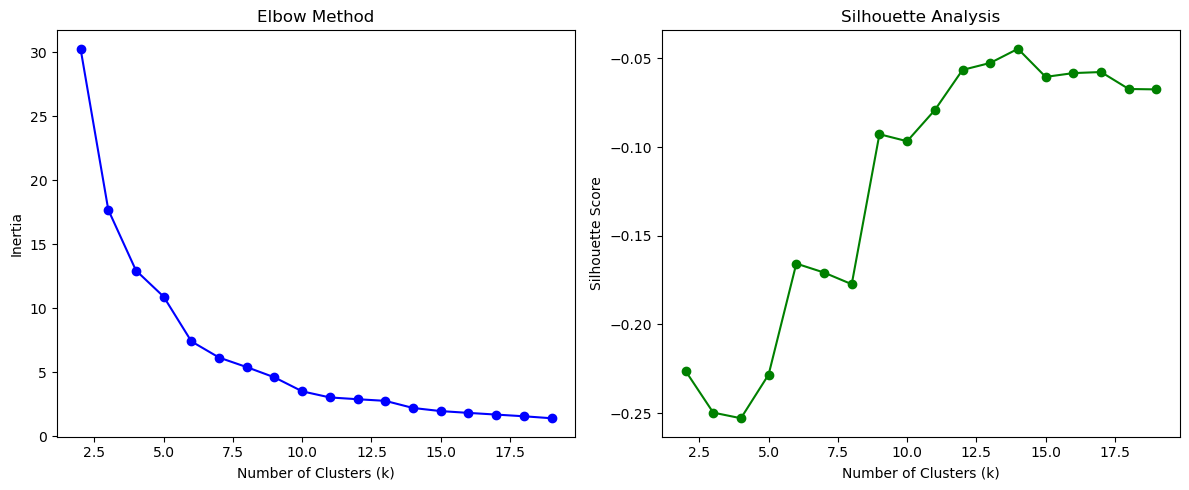

In [35]:
from sklearn.metrics import silhouette_score

# Elbow Method
inertia = []
silhouette_scores = []
K = range(2, 20)

for n in K:
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(customer_data_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(customer_data_rfm, kmeans.labels_))

# Plot Elbow Method
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'go-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')

plt.tight_layout()
plt.show()

### Applying **DBSCAN** for clustering based on density

In [37]:
# Applying DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
customer_data_rfm['DB_Cluster'] = dbscan.fit_predict(customer_data_scaled)

# Inspect clusters
print(customer_data_rfm.groupby('DB_Cluster').mean())

              CustomerID    Recency   Frequency     Monetary  K_Cluster
DB_Cluster                                                             
0           15299.677722  24.415828  123.949909  2229.585529   3.350183


In [39]:
# Sample output of clusters
print("Both Custers Output:")
print(customer_data_rfm.head(10))

Both Custers Output:
   CustomerID  Recency  Frequency  Monetary  K_Cluster  DB_Cluster
0     12346.0      231          3      4.92          5           0
1     12347.0        1        239   4853.06          4           0
2     12348.0        0         40   1859.28          4           0
3     12349.0        1        103   2071.40          4           0
4     12350.0        0         24    440.22          4           0
5     12352.0        7        124   1754.58          4           0
6     12353.0      155          6     90.63          1           0
7     12354.0        3         72   1208.66          4           0
8     12355.0        1         20    516.49          4           0
9     12356.0        1         78   3856.14          4           0


# **Visualization and Insights**

### Appling **PCA** for 2D visualization

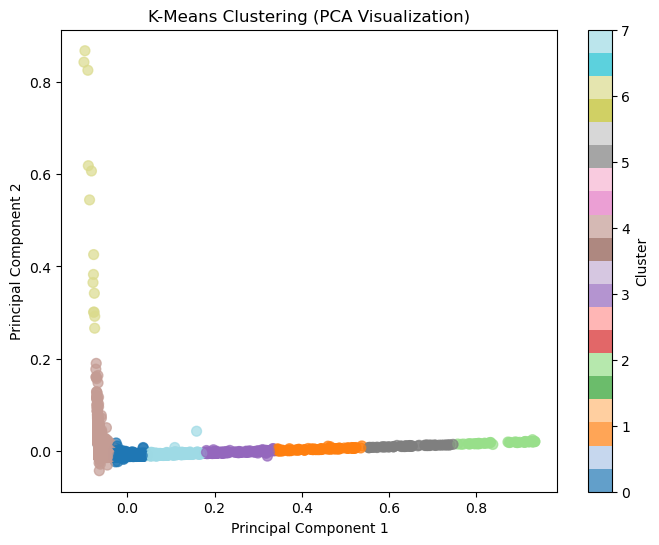

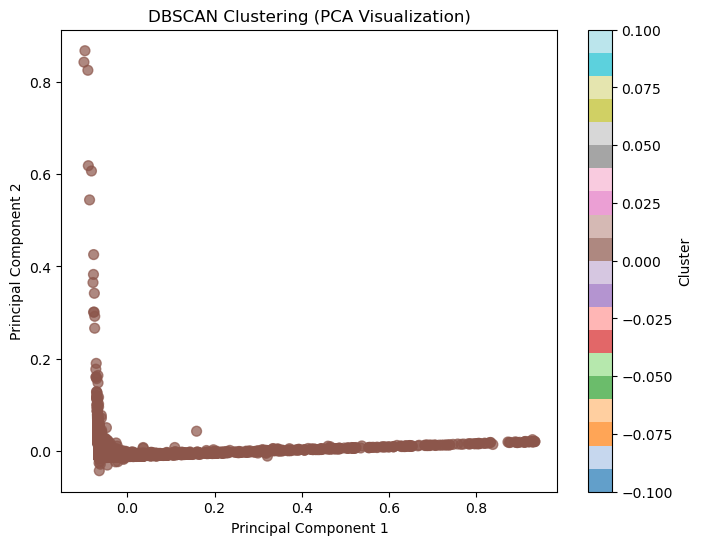

In [41]:
# Applying PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(customer_data_scaled)
map = "tab20"

# Plot for K-Means Clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=customer_data_rfm['K_Cluster'], cmap = map, s=50, alpha=0.7)
plt.title('K-Means Clustering (PCA Visualization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Plot for DBSCAN Clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=customer_data_rfm['DB_Cluster'], cmap = map, s=50, alpha=0.7)
plt.title('DBSCAN Clustering (PCA Visualization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()


### Applying **t-SNE** for 3D visualization

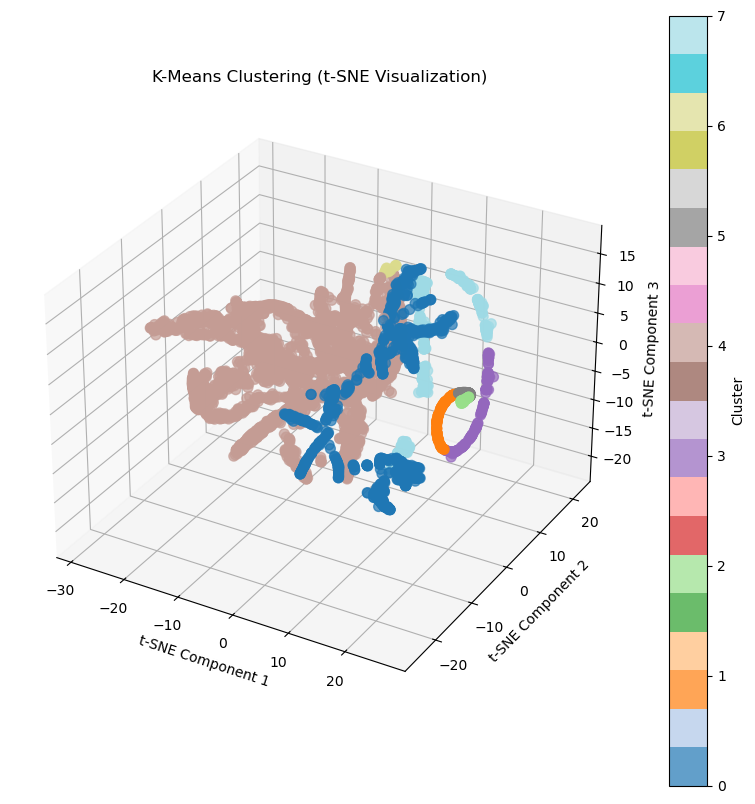

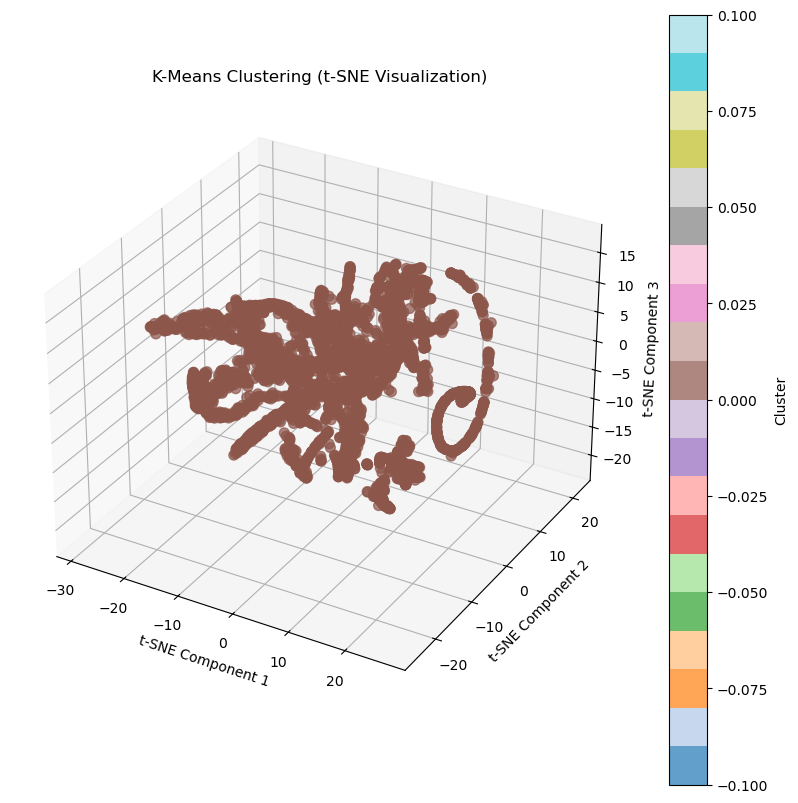

In [43]:
# Applying t-SNE for 3D visualization
tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(customer_data_scaled)

# 3D Scatter Plot For K-Means
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=customer_data_rfm['K_Cluster'], cmap = map, s=50, alpha=0.7)
ax.set_title('K-Means Clustering (t-SNE Visualization)')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
plt.colorbar(scatter, label='Cluster')
plt.show()

# 3D Scatter Plot for DBSCAN
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=customer_data_rfm['DB_Cluster'], cmap = map, s=50, alpha=0.7)
ax.set_title('K-Means Clustering (t-SNE Visualization)')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
plt.colorbar(scatter, label='Cluster')
plt.show()

# **Marketing Strategies for Customer Segments**
**Loyal Customers (Cluster 0)**  
  **RFM Values:** **`Recency`**: 73 Days, **`Frequency`**: 54.75, **`Monetary`**: ≈ 1,006  
  Customers in this segment have made frequent purchases in the past and are highly engaged. To maintain their loyalty, **Loyalty Programs** should be implemented, offering exclusive rewards or discounts for repeat purchases. Personalized content such as VIP offers or special birthday/anniversary deals can further enhance engagement.

**Dormant Customers (Cluster 1)**  
  **RFM Values:** **`Recency`**: 260 Days, **`Frequency`**: 23.65, **`Monetary`**: ≈ 476  
  Customers who have not engaged with the brand for a while are in this segment. **Re-engagement Campaigns** are ideal, including personalized reactivation emails or SMS with special offers. Discounts or promotions can be provided to reignite their interest and bring them back into the funnel.

**Moderately Engaged (Cluster 2)**  
  **RFM Values:** **`Recency`**: 129 Days, **`Frequency`**: 45.22, **`Monetary`**: ≈ 761  
  These customers are somewhat active, but not as frequently as loyal customers. **Product Recommendations** based on their previous behavior can encourage them to engage more. Time-sensitive offers can also be used to increase purchase frequency and boost their overall engagement.

**Very Inactive Customers (Cluster 3)**  
  **RFM Values:** **`Recency`**: 338 Days, **`Frequency`**: 23.33, **`Monetary`**: ≈ 322  
  These customers are the least engaged, having a long time since their last purchase. **Targeted Promotions** should be used to reach them, offering deep discounts or limited-time offers to attract attention. It’s also beneficial to send a survey or request feedback to understand their inactivity and potentially win them back.

**Occasional Shoppers (Cluster 4)**  
  **RFM Values:** **`Recency`**: 191 Days, **`Frequency`**: 33.43, **`Monetary`**: ≈ 559  
  Customers in this group shop occasionally and have a moderate engagement level. **Personalized Offers** based on past shopping habits can encourage them to make more frequent purchases. Highlighting new arrivals or seasonal promotions can also help to maintain interest and increase engagement.

**High Activity Customers (Cluster 5)**  
  **RFM Values:** **`Recency`**: 9 Days, **`Frequency`**: 153.45, **`Monetary`**: ≈ 2,982  
  These customers are highly engaged and make frequent purchases. To keep them engaged, **Exclusive VIP Access** to sneak peeks or early access to new products or services is effective. Special offers like bundle deals or loyalty bonuses can also help maintain high engagement and reward their loyalty.

**Frequent Shoppers (Cluster 6)**  
  **RFM Values:** **`Recency`**: 36 Days, **`Frequency`**: 81.50, **`Monetary`**: ≈ 1,335  
  This segment consists of customers who purchase regularly but may not spend as much as high activity customers. **Loyalty and Upselling** should be the focus, with loyalty points for frequent shopping and cross-selling or upselling complementary products. Personalized recommendations can encourage repeat visits and keep them engaged.

**Top Spenders (Cluster 7)**  
  **RFM Values:** **`Recency`**: 4 Days, **`Frequency`**: 2,845.58, **`Monetary`**: ≈ 118,713  
  These customers are the highest spenders, showing the greatest value to the business. **High-Touch Concierge Service** is essential to maintain their loyalty. Offering exclusive, high-value offers, customized gifts, VIP events, or personalized loyalty programs can further incentivize continued spending.
